In [1]:
import snoglode as sno
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from farmer_problem import TwoStageFarmer
import os

np.random.seed(42)

In [2]:
def subproblem_creator(scenario_name):
    """
    Based on the scenario, generates 
        1) the pyomo model
        2) the dict of lifted variable IDS : pyo.Var
        3) the list of subprob lem specific variables (pyo.Vars)
        3) probability of subproblem
    and returns as a list in this order.
    """
    name_to_yield_map = {
        "good": 1.2,
        "fair": 1.0,
        "bad": 0.8
    }
    
    # create parameters / model stored in obj for this scenario
    farmer_scenario = TwoStageFarmer(name_to_yield_map[scenario_name])

    # grab the list of first stage variables
    lifted_variable_ids = {("devoted_acrege", crop): farmer_scenario.model.x[crop] \
                                for crop in farmer_scenario.planting_crops}
    
    # probability of this particular scenario occuring
    scenario_probability = 1/3

    return [farmer_scenario.model,              # pyomo model corresponding to this subproblem
            lifted_variable_ids,                # lifted varID : pyo.Var dict
            scenario_probability]               # probability of this subproblem

In [3]:
subproblem_names = ["good", "fair", "bad"]
params = sno.SolverParameters(subproblem_names = subproblem_names,
                                subproblem_creator = subproblem_creator,
                                lb_solver = pyo.SolverFactory("gurobi"),
                                cg_solver = pyo.SolverFactory("gurobi"),
                                ub_solver = pyo.SolverFactory("gurobi"))
params.set_bounds_tightening(False, False)
params.set_branching(selection_strategy=sno.RandomSelection,
                     partition_strategy=sno.Midpoint)

        Time (s)  Nodes Explored       Pruned by                              LB              UB        Rel. Gap        Abs. Gap         # Nodes
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
           0.017               1                           * L U      -115405.56       -108390.0         6.4725%     7015.555556               2
           0.032               2                                      -115405.56       -108390.0         6.4725%     7015.555556               3
           0.038               3           Bound                      -115405.56       -108390.0         6.4725%     7015.555556               2
           0.048               4                                      -115405.56       -108390.0         6.4725%     7015.555556               3
            0.06               5                                      -115405.56       -108390.0       

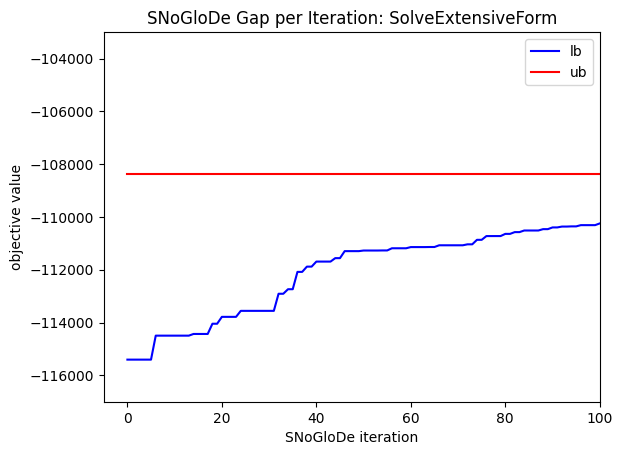

In [4]:


params.set_bounders(candidate_solution_finder=sno.SolveExtensiveForm)
params.set_branching(selection_strategy=sno.RandomSelection,
                     partition_strategy=sno.Midpoint)
solver = sno.Solver(params)
solver.solve(max_iter=100,
             collect_plot_info=True,
             rel_tolerance=1e-4)

num_iters = np.arange(solver.iteration)
plt.plot(num_iters, solver.plotter.iter_lb, label = "lb", color="blue")
plt.plot(num_iters, solver.plotter.iter_ub, label = "ub", color="red")
plt.legend()
plt.xlabel("SNoGloDe iteration")
plt.ylabel("objective value")
plt.ylim(-117000, -103000)   # set y-axis 
plt.xlim(right=100)   # set y-axis 
plt.title("SNoGloDe Gap per Iteration: SolveExtensiveForm");
plt.savefig("farmer_solve_extensive_form.png",
            dpi=300)

        Time (s)  Nodes Explored       Pruned by                              LB              UB        Rel. Gap        Abs. Gap         # Nodes
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
           0.013               1                           * L U      -115405.56      -103716.67          11.27%    11688.888889               2
           0.028               2                           * U        -115405.56      -108374.44         6.4878%     7031.111111               3
           0.044               3                                      -115405.56      -108374.44         6.4878%     7031.111111               4
           0.059               4                                      -115405.56      -108374.44         6.4878%     7031.111111               5
           0.064               5           Bound                      -115405.56      -108374.44       

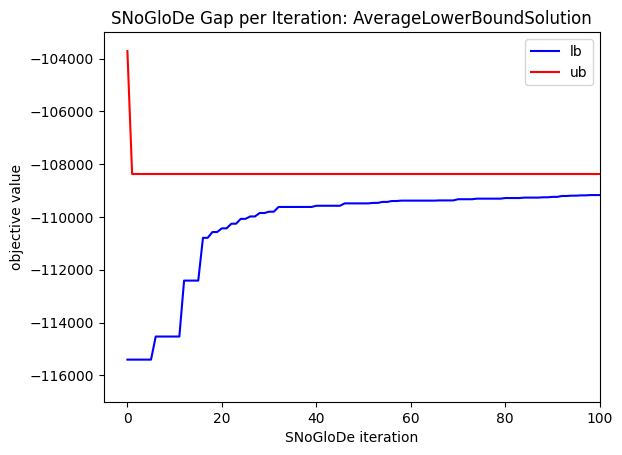

In [5]:
params.set_bounders(candidate_solution_finder=sno.AverageLowerBoundSolution)
params.set_branching(selection_strategy=sno.RandomSelection,
                     partition_strategy=sno.Midpoint)
solver = sno.Solver(params)
solver.solve(max_iter=100,
             collect_plot_info=True,
             rel_tolerance=1e-4)

num_iters = np.arange(solver.iteration)
plt.plot(num_iters, solver.plotter.iter_lb, label = "lb", color="blue")
plt.plot(num_iters, solver.plotter.iter_ub, label = "ub", color="red")
plt.legend()
plt.xlabel("SNoGloDe iteration")
plt.ylabel("objective value")
plt.ylim(-117000, -103000)   # set y-axis 
plt.xlim(right=100)   # set y-axis 
plt.title("SNoGloDe Gap per Iteration: AverageLowerBoundSolution");
plt.savefig("farmer_solve_average_lb.png",
            dpi=300)

        Time (s)  Nodes Explored       Pruned by                              LB              UB        Rel. Gap        Abs. Gap         # Nodes
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
           0.019               1                           * L U      -115405.56      -103716.67          11.27%    11688.888889               2
            0.03               2                                      -115405.56      -103716.67          11.27%    11688.888889               3
           0.036               3           Bound                      -115405.56      -103716.67          11.27%    11688.888889               2
           0.046               4                                      -115405.56      -103716.67          11.27%    11688.888889               3
           0.055               5                           * U        -115405.56       -106300.0       

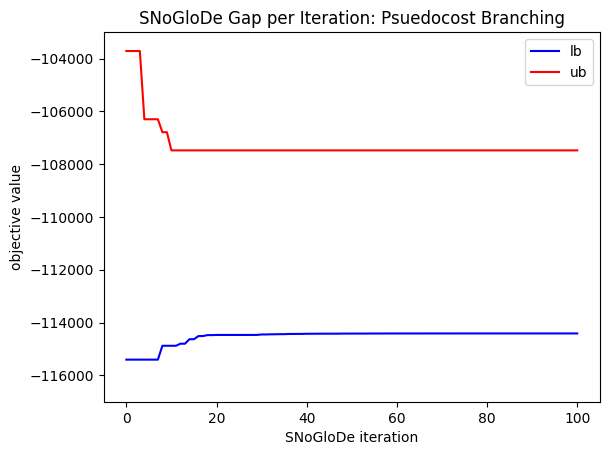

In [6]:
params.set_bounders(candidate_solution_finder=sno.AverageLowerBoundSolution)
params.set_branching(selection_strategy=sno.Pseudocost,
                     partition_strategy=sno.Midpoint)
solver = sno.Solver(params)
solver.solve(max_iter=100,
             collect_plot_info=True)

num_iters = np.arange(solver.iteration)
plt.plot(num_iters, solver.plotter.iter_lb, label = "lb", color="blue")
plt.plot(num_iters, solver.plotter.iter_ub, label = "ub", color="red")
plt.legend()
plt.xlabel("SNoGloDe iteration")
plt.ylabel("objective value")
plt.ylim(-117000, -103000)   # set y-axis 
plt.title("SNoGloDe Gap per Iteration: Psuedocost Branching");
plt.savefig("farmer_solve_average_lb_pseudocost.png",
            dpi=300)

        Time (s)  Nodes Explored       Pruned by                              LB              UB        Rel. Gap        Abs. Gap         # Nodes
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
            0.02               1                           * L U      -115405.56      -103716.67          11.27%    11688.888889               2
           0.041               2                           * U        -115405.56      -108374.44         6.4878%     7031.111111               3
           0.053               3                                      -115405.56      -108374.44         6.4878%     7031.111111               4
           0.065               4                                      -115405.56      -108374.44         6.4878%     7031.111111               5
           0.071               5           Bound                      -115405.56      -108374.44       

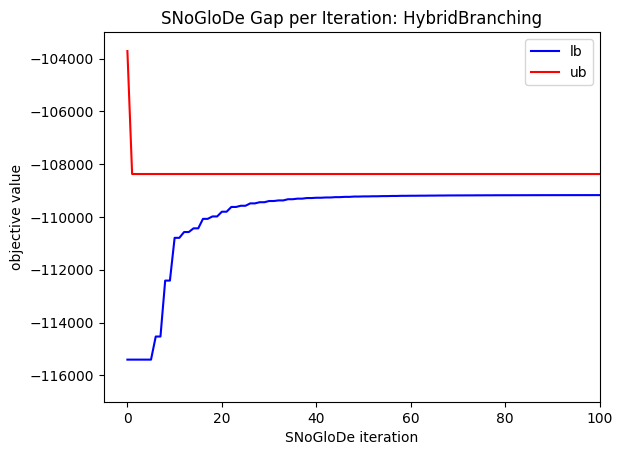

In [7]:
params.set_bounders(candidate_solution_finder=sno.AverageLowerBoundSolution)
params.set_branching(selection_strategy=sno.HybridBranching,
                     partition_strategy=sno.Midpoint)
solver = sno.Solver(params)
solver.solve(max_iter=100,
             collect_plot_info=True,
             rel_tolerance=1e-4)

num_iters = np.arange(solver.iteration)
plt.plot(num_iters, solver.plotter.iter_lb, label = "lb", color="blue")
plt.plot(num_iters, solver.plotter.iter_ub, label = "ub", color="red")
plt.legend()
plt.xlabel("SNoGloDe iteration")
plt.ylabel("objective value")
plt.ylim(-117000, -103000)   # set y-axis 
plt.xlim(right=100)   # set y-axis 
plt.title("SNoGloDe Gap per Iteration: HybridBranching");
plt.savefig("farmer_solve_average_lb_hybrid.png",
            dpi=300)

        Time (s)  Nodes Explored       Pruned by                              LB              UB        Rel. Gap        Abs. Gap         # Nodes
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
           0.034               1                           * L U      -115405.56      -103716.67          11.27%    11688.888889               2
           0.046               2                           * U        -115405.56      -108374.44         6.4878%     7031.111111               3
           0.068               3                                      -115405.56      -108374.44         6.4878%     7031.111111               4
           0.078               4                                      -115405.56      -108374.44         6.4878%     7031.111111               5
           0.084               5           Bound                      -115405.56      -108374.44       

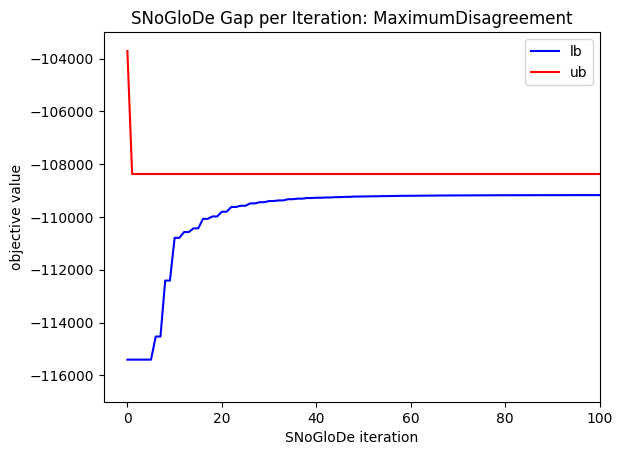

In [8]:
params.set_bounders(candidate_solution_finder=sno.AverageLowerBoundSolution)
params.set_branching(selection_strategy=sno.MaximumDisagreement,
                     partition_strategy=sno.Midpoint)
solver = sno.Solver(params)
solver.solve(max_iter=100,
             collect_plot_info=True,
             rel_tolerance=1e-4)

num_iters = np.arange(solver.iteration)
plt.plot(num_iters, solver.plotter.iter_lb, label = "lb", color="blue")
plt.plot(num_iters, solver.plotter.iter_ub, label = "ub", color="red")
plt.legend()
plt.xlabel("SNoGloDe iteration")
plt.ylabel("objective value")
plt.ylim(-117000, -103000)   # set y-axis 
plt.xlim(right=100)   # set y-axis 
plt.title("SNoGloDe Gap per Iteration: MaximumDisagreement");
plt.savefig("farmer_solve_average_lb_maxdis.png",
            dpi=300)

        Time (s)  Nodes Explored       Pruned by                              LB              UB        Rel. Gap        Abs. Gap         # Nodes
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
           0.017               1                           * L U      -115405.56      -103716.67          11.27%    11688.888889               2
           0.026               2                                      -115405.56      -103716.67          11.27%    11688.888889               3
           0.034               3           Bound                      -115405.56      -103716.67          11.27%    11688.888889               2
           0.045               4                                      -115405.56      -103716.67          11.27%    11688.888889               3
           0.052               5           Bound                      -115405.56      -103716.67       

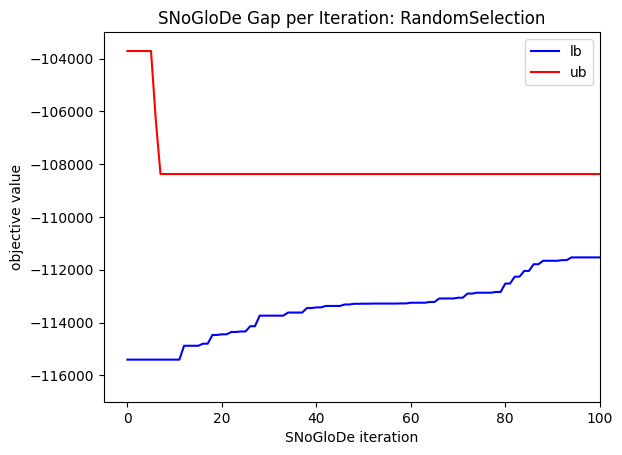

In [9]:
params.set_bounders(candidate_solution_finder=sno.AverageLowerBoundSolution)
params.set_branching(selection_strategy=sno.RandomSelection,
                     partition_strategy=sno.Midpoint)
solver = sno.Solver(params)
solver.solve(max_iter=100,
             collect_plot_info=True,
             rel_tolerance=1e-4)

num_iters = np.arange(solver.iteration)
plt.plot(num_iters, solver.plotter.iter_lb, label = "lb", color="blue")
plt.plot(num_iters, solver.plotter.iter_ub, label = "ub", color="red")
plt.legend()
plt.xlabel("SNoGloDe iteration")
plt.ylabel("objective value")
plt.ylim(-117000, -103000)   # set y-axis 
plt.xlim(right=100)   # set y-axis 
plt.title("SNoGloDe Gap per Iteration: RandomSelection");
plt.savefig("farmer_solve_average_lb_random.png",
            dpi=300)

        Time (s)  Nodes Explored       Pruned by                              LB              UB        Rel. Gap        Abs. Gap         # Nodes
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
           0.034               1                           * L U      -115405.56      -103716.67          11.27%    11688.888889               2
            0.05               2                                      -115405.56      -103716.67          11.27%    11688.888889               3
           0.062               3                           * L U      -114954.44      -106657.41         7.7791%     8297.037037               4
           0.073               4                                      -114954.44      -106657.41         7.7791%     8297.037037               5
           0.084               5                           * U        -114954.44      -107412.33       

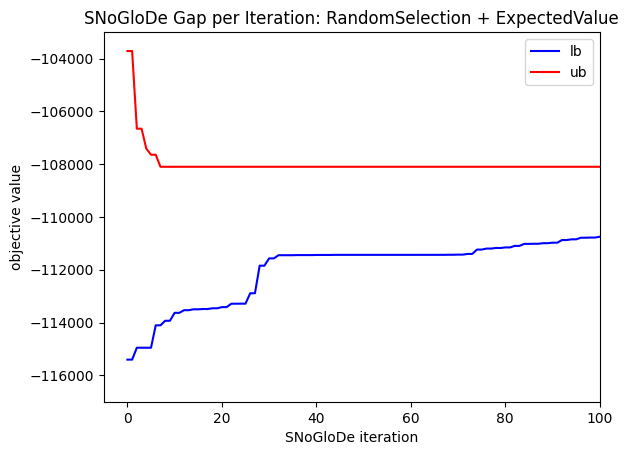

In [10]:
params.set_bounders(candidate_solution_finder=sno.AverageLowerBoundSolution)
params.set_branching(selection_strategy=sno.RandomSelection,
                     partition_strategy=sno.ExpectedValue)
solver = sno.Solver(params)
solver.solve(max_iter=100,
             collect_plot_info=True,
             rel_tolerance=1e-4)

num_iters = np.arange(solver.iteration)
plt.plot(num_iters, solver.plotter.iter_lb, label = "lb", color="blue")
plt.plot(num_iters, solver.plotter.iter_ub, label = "ub", color="red")
plt.legend()
plt.xlabel("SNoGloDe iteration")
plt.ylabel("objective value")
plt.ylim(-117000, -103000)   # set y-axis 
plt.xlim(right=100)   # set y-axis 
plt.title("SNoGloDe Gap per Iteration: RandomSelection + ExpectedValue");
plt.savefig("farmer_solve_average_lb_random_ev.png",
            dpi=300)

        Time (s)  Nodes Explored       Pruned by                              LB              UB        Rel. Gap        Abs. Gap         # Nodes
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
            0.02               1                           * L U      -115405.56      -103716.67          11.27%    11688.888889               2
           0.039               2                           * U        -115405.56       -107530.0         7.3241%     7875.555556               3
           0.046               3           Bound           * L        -114472.22       -107530.0         6.4561%     6942.222222               2
           0.058               4                           * U        -114472.22      -107952.78         6.0392%     6519.444444               3
           0.069               5                           * L        -112023.06      -107952.78       

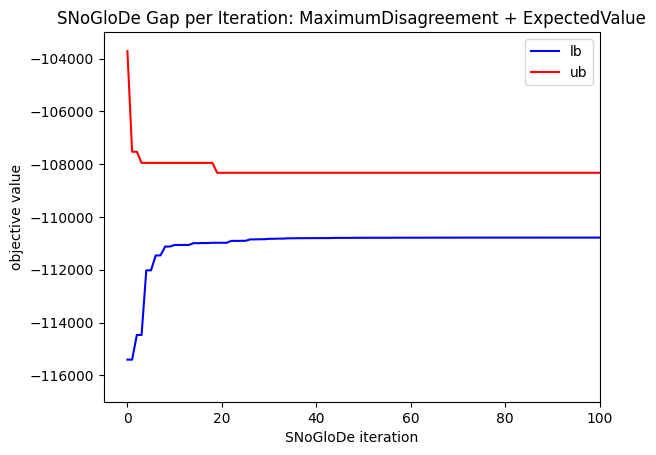

In [11]:
params.set_bounders(candidate_solution_finder=sno.AverageLowerBoundSolution)
params.set_branching(selection_strategy=sno.MaximumDisagreement,
                     partition_strategy=sno.ExpectedValue)
solver = sno.Solver(params)
solver.solve(max_iter=100,
             collect_plot_info=True,
             rel_tolerance=1e-4)

num_iters = np.arange(solver.iteration)
plt.plot(num_iters, solver.plotter.iter_lb, label = "lb", color="blue")
plt.plot(num_iters, solver.plotter.iter_ub, label = "ub", color="red")
plt.legend()
plt.xlabel("SNoGloDe iteration")
plt.ylabel("objective value")
plt.ylim(-117000, -103000)   # set y-axis 
plt.xlim(right=100)   # set y-axis 
plt.title("SNoGloDe Gap per Iteration: MaximumDisagreement + ExpectedValue");
plt.savefig("farmer_solve_average_lb_maxdis_ev.png",
            dpi=300)

        Time (s)  Nodes Explored       Pruned by                              LB              UB        Rel. Gap        Abs. Gap         # Nodes
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
            0.02               1                           * L U      -115405.56      -103716.67          11.27%    11688.888889               2
           0.039               2                                      -115405.56      -103716.67          11.27%    11688.888889               3
            0.05               3                           * L U      -114954.44      -106657.41         7.7791%     8297.037037               4
           0.059               4                                      -114954.44      -106657.41         7.7791%     8297.037037               5
           0.068               5                           * U        -114954.44      -107412.33       

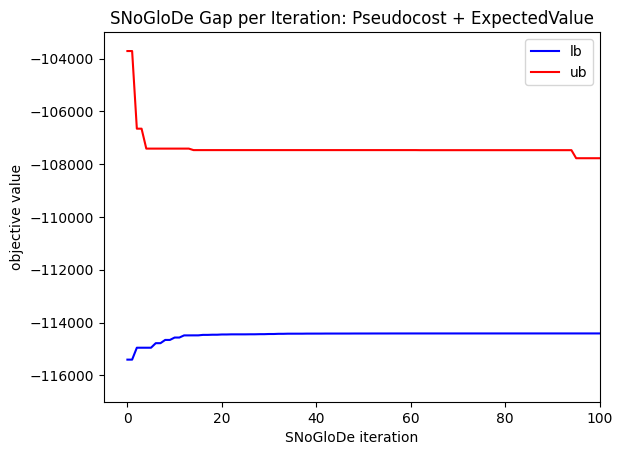

In [14]:
params.set_bounders(candidate_solution_finder=sno.AverageLowerBoundSolution)
params.set_branching(selection_strategy=sno.Pseudocost,
                     partition_strategy=sno.ExpectedValue)
solver = sno.Solver(params)
solver.solve(max_iter=100,
             collect_plot_info=True,
             rel_tolerance=1e-4)

num_iters = np.arange(solver.iteration)
plt.plot(num_iters, solver.plotter.iter_lb, label = "lb", color="blue")
plt.plot(num_iters, solver.plotter.iter_ub, label = "ub", color="red")
plt.legend()
plt.xlabel("SNoGloDe iteration")
plt.ylabel("objective value")
plt.ylim(-117000, -103000)   # set y-axis 
plt.xlim(right=100)   # set y-axis 
plt.title("SNoGloDe Gap per Iteration: Pseudocost + ExpectedValue");
plt.savefig("farmer_solve_average_lb_pseudocost_ev.png",
            dpi=300)

        Time (s)  Nodes Explored       Pruned by                              LB              UB        Rel. Gap        Abs. Gap         # Nodes
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
           0.037               1                           * L U      -115405.56      -103716.67          11.27%    11688.888889               2
           0.051               2                           * U        -115405.56       -107530.0         7.3241%     7875.555556               3
           0.057               3           Bound           * L        -114472.22       -107530.0         6.4561%     6942.222222               2
           0.069               4                           * U        -114472.22      -107952.78         6.0392%     6519.444444               3
           0.079               5                           * L        -112023.06      -107952.78       

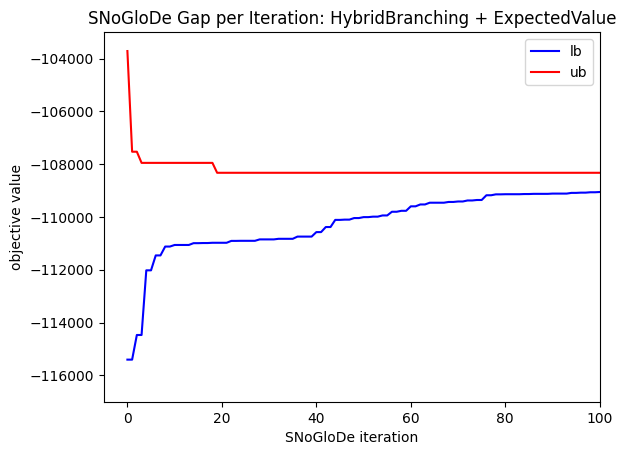

In [13]:
params.set_bounders(candidate_solution_finder=sno.AverageLowerBoundSolution)
params.set_branching(selection_strategy=sno.HybridBranching,
                     partition_strategy=sno.ExpectedValue)
solver = sno.Solver(params)
solver.solve(max_iter=100,
             collect_plot_info=True,
             rel_tolerance=1e-4)

num_iters = np.arange(solver.iteration)
plt.plot(num_iters, solver.plotter.iter_lb, label = "lb", color="blue")
plt.plot(num_iters, solver.plotter.iter_ub, label = "ub", color="red")
plt.legend()
plt.xlabel("SNoGloDe iteration")
plt.ylabel("objective value")
plt.ylim(-117000, -103000)   # set y-axis 
plt.xlim(right=100)   # set y-axis 
plt.title("SNoGloDe Gap per Iteration: HybridBranching + ExpectedValue");
plt.savefig("farmer_solve_average_lb_hybrid_ev.png",
            dpi=300)